### **Generate test multiscale patches from test scenes.**
### We randomly select 10 scenes (from 39 scenes), and the scene id is in the config file.

In [1]:
import os
os.chdir('..')
from notebooks import config
import torch
import glob
import numpy as np
from dataloader.preprocess import crop_scales, crop
from dataloader.preprocess import read_normalize
from utils.imgShow import imgShow,imsShow
import matplotlib.pyplot as plt
import random
import cv2


In [2]:
### check the validation data is not contained in the training data
if len(list(set(config.val_ids)-set(config.tra_ids))) - len(config.val_ids) == 0:
  print('Validation sites:', config.val_ids)
  print('The validation scenes are not contained in the traning scenes')
else:
  print('Warning: Some validation scenes are contained in the traning scenes')



Validation sites: ['01', '02', '03', '04', '05', '06', '07']
The validation scenes are not contained in the traning scenes


In [3]:
## ---------- Validation data paths ----------- #
paths_val_as, paths_val_des, paths_val_truth = [], [], []
for val_id in config.val_ids:
  as_name = 'scene'+val_id+'_s1as_pad.tif'
  des_name = 'scene'+val_id+'_s1des_pad.tif'
  truth_name = 'scene'+val_id+'_wat_truth_pad.tif'
  paths_val_as.append(config.dir_as + '/' + as_name); 
  paths_val_des.append(config.dir_des + '/' + des_name);
  paths_val_truth.append(config.dir_truth + '/' + truth_name)

print(paths_val_as[0])
print(paths_val_truth[0])
print(len(paths_val_as))


/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_ascend_clean/scene01_s1as_pad.tif
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_truth_clean/scene01_wat_truth_pad.tif
7


In [4]:
### ----- data read & pre-processing ------- ###
val_scene_list, val_truth_list = read_normalize(paths_as=paths_val_as, paths_des=paths_val_des, \
          paths_truth=paths_val_truth, max_bands=config.s1_max, min_bands=config.s1_min)
ziped_val_data = list(zip(val_scene_list, val_truth_list))
len(ziped_val_data)


7

### Validation data preparation
#### 1. Generate (patches, truth) test data, the patches is a list, consist of patches in three scales.

In [5]:
'''---- First 6 scenes are used for validation: generate (patch_group, truth) test data----'''
num_patch = 0
random.seed(9999)

for i in range(50):
    print(i)
    for scene, truth in ziped_val_data:
        patches, ptruth = crop_scales(scales=(2048, 512, 256))(image=scene, truth=truth)
        patches = [torch.from_numpy(patch).to(dtype=torch.float16) for patch in patches] # 
        ptruth = torch.from_numpy(ptruth).long()
        ptruth = torch.unsqueeze(ptruth,0)
        path_save = config.root_proj+'/data/dset/s1_val_patches/patch_'+ str(num_patch).rjust(3,'0')+'.pt'
        num_patch += 1
        print(path_save)
        torch.save((patches, ptruth), path_save)



0
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_000.pt
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_001.pt
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_002.pt
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_003.pt
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_004.pt
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_005.pt
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_006.pt
1
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_007.pt
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_val_patches/patch_008.pt
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_v

### Check

In [6]:
## load data
paths_patch_val = sorted(glob.glob(config.dir_patch_val+'/*'))
patch_list_val = [torch.load(path) for path in paths_patch_val]
print(len(patch_list_val))


350


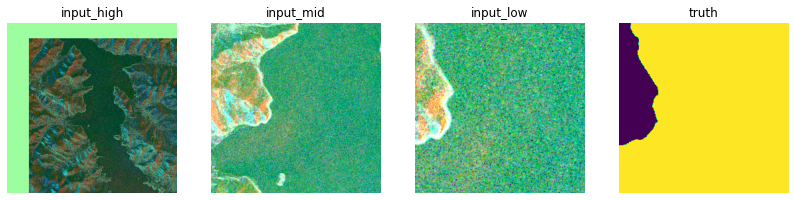

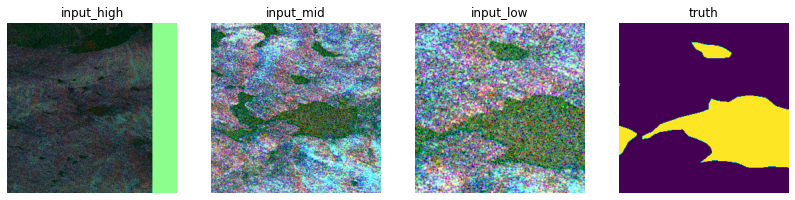

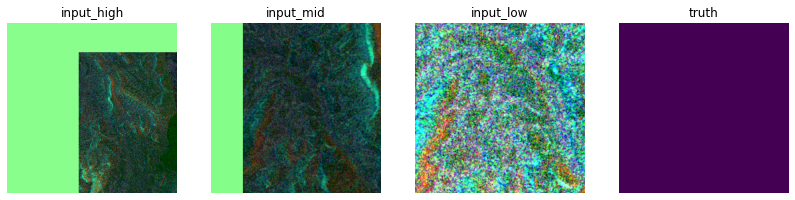

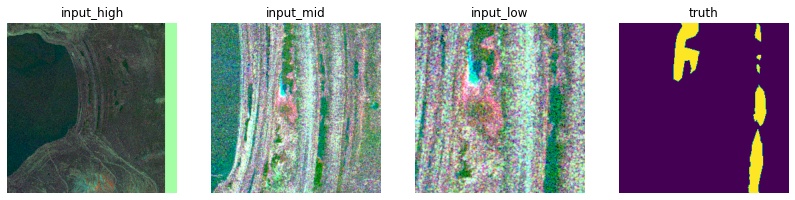

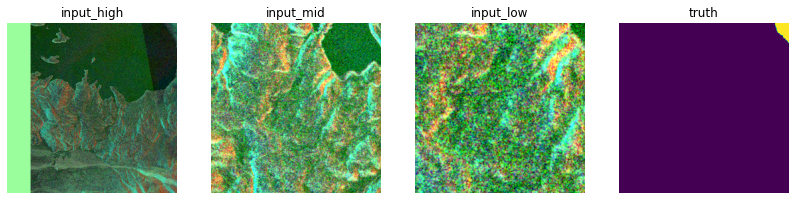

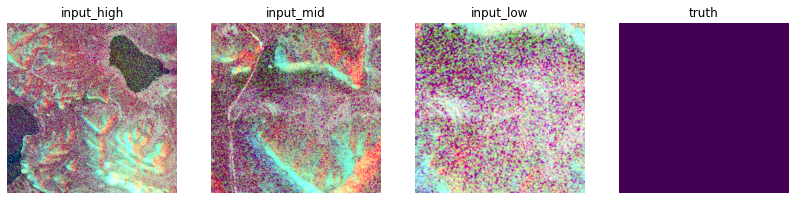

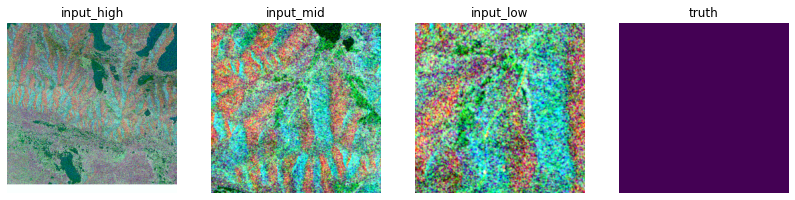

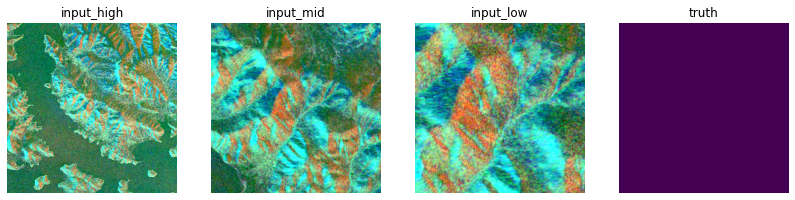

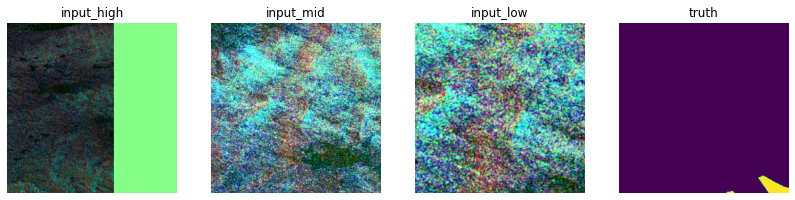

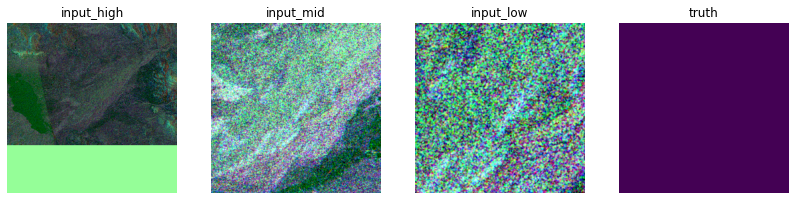

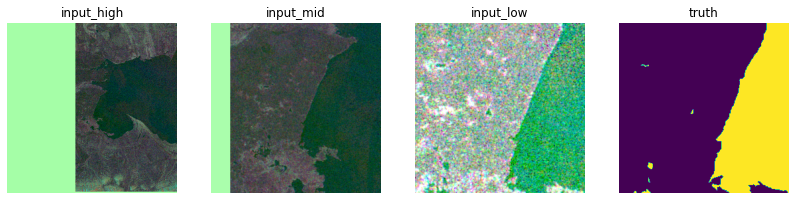

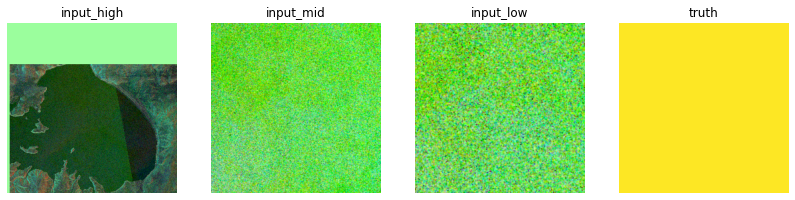

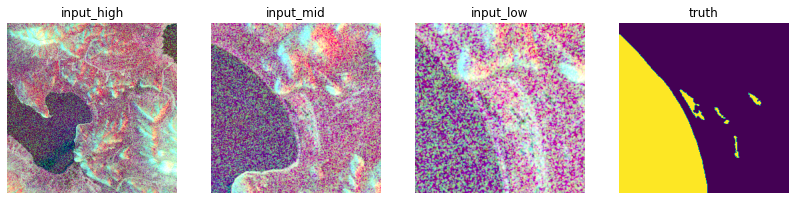

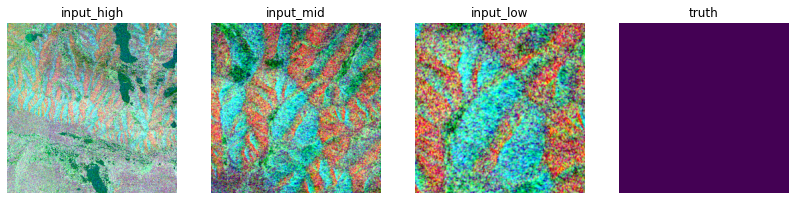

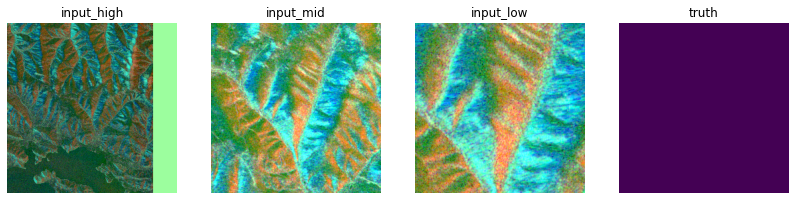

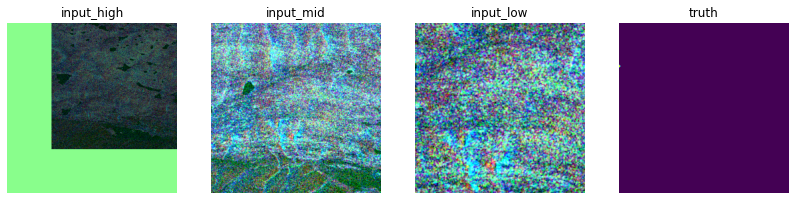

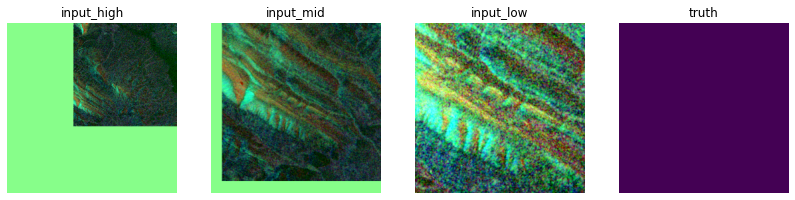

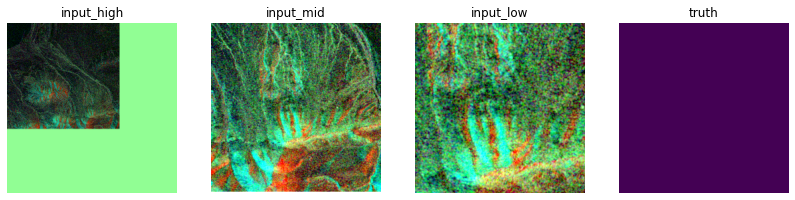

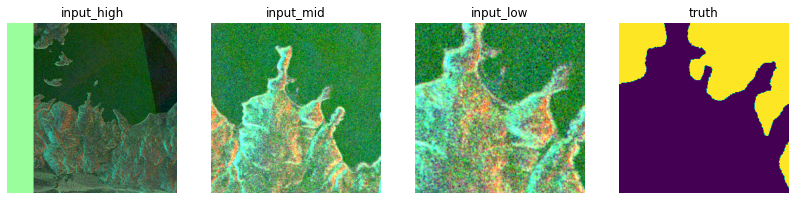

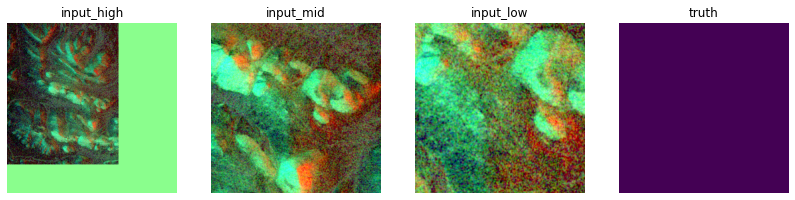

In [7]:
# idx = 16
# idx = random.randint(0,500)
for idx in range(100,120):
  # print(idx)
  patches, truth = patch_list_val[idx]  ## (patches, truth)
  patches_ = [patch.numpy().transpose(1,2,0).astype(np.float32) for patch in patches]
  truth = truth.numpy().transpose(1,2,0)
  patches_[0].shape
  patches_list = [patches_[0],patches_[1],patches_[2],truth]
  patches_name = ['input_high','input_mid','input_low','truth']
  clip_list = [2,2,2,0]
  col_bands_list = [(2,1,0), (2,1,0), (2,1,0), (0,0,0)]
  plt.figure(figsize=(14,5))
  imsShow(img_list=patches_list, img_name_list=patches_name, \
                                  clip_list=clip_list, color_bands_list=col_bands_list)
